I will pratice my pytorch skills in this notebook by writing an image classification alogrithm using Pytorch. This is based on the tutorial on this page: https://www.pluralsight.com/guides/image-classification-with-pytorch
The data could be downloaded from here: https://www.kaggle.com/c/aerial-cactus-identification/data
Please unzip the data to make the directory to have the following structure:
```
aerialcactus/
    train.csv
    sample_submission.csv
    train/
        train/
        *.jpg
    test/
        test/
            *.jpg
```

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [76]:
labels = pd.read_csv('../data/aerialcactus/train.csv')
submission = pd.read_csv('../data/aerialcactus/sample_submission.csv')
train_path = '../data/aerialcactus/train/train'
test_path = '../data/aerialcactus/test/test'

In [77]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [79]:
labels.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [78]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

([<matplotlib.patches.Wedge at 0x2614b1dd840>,
 [Text(-0.7762799652368623, 0.7793519202336362, 'Has Cactus'),
  Text(0.7762800017209579, -0.7793518838933475, "Hasn't Cactus")],
 [Text(-0.423425435583743, 0.42510104740016513, '24.9%'),
  Text(0.42342545548415883, -0.4251010275781895, '75.1%')])

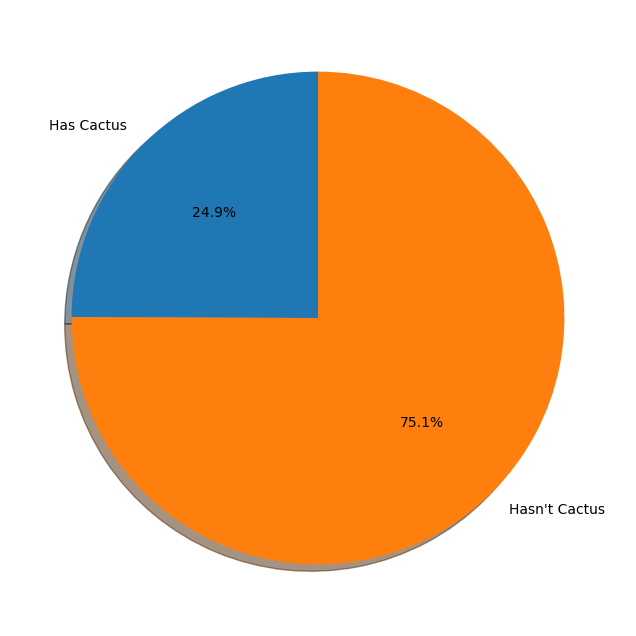

In [80]:
label = 'Has Cactus', 'Hasn\'t Cactus'
plt.figure(figsize=(8,8))
plt.pie(labels.groupby('has_cactus').size(), labels=label, autopct='%1.1f%%', shadow=True, startangle=90)

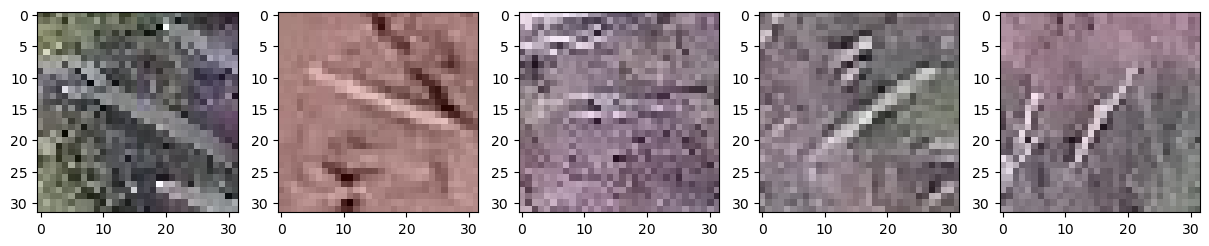

In [81]:
import matplotlib.image as img
import os

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for idx, filename in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
    path = os.path.join(train_path, filename)
    ax[idx].imshow(img.imread(path))

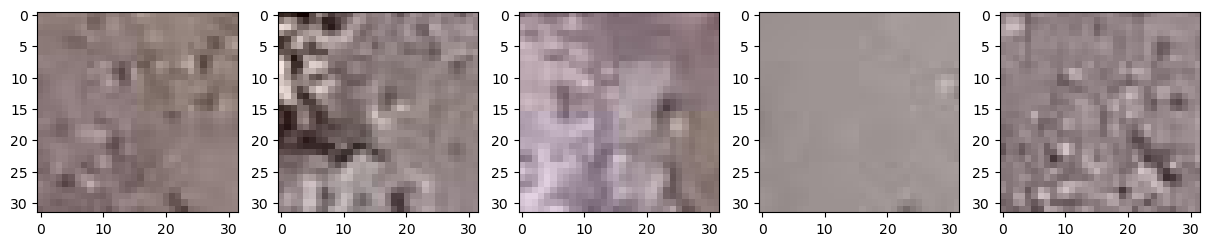

In [82]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for idx, filename in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
    path = os.path.join(train_path, filename)
    ax[idx].imshow(img.imread(path))

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# The mean and std are the mean and std from ImageNet which is widely used in computer vision tasks for normalizing images
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def imshow(image, ax=None, title=None, normalize=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        image = std * image + mean  # convert the normalized images to the original image
        image = np.clip(image, 0, 1)  # avoid the overflow/underflow problems caused by numerical computation
    
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [84]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [85]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

In [86]:
class CactiDataset(Dataset):
    def __init__(self, data, path, transform=None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


train_data = CactiDataset(train, train_path, train_transform)
valid_data = CactiDataset(valid_data, train_path, valid_transform)
test_data = CactiDataset(submission, test_path, test_transform)

In [87]:
num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001
device = 'cuda'

In [88]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 32, 32])


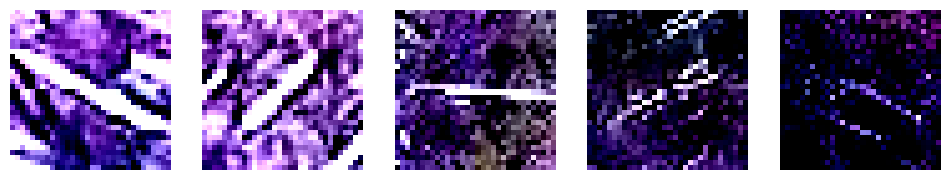

In [89]:
trainimages, trainlabels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe = axes[i]
    imshow(trainimages[i], ax=axe, normalize=False)

print(trainimages[0].size())

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)   # 32x32x3 => 15x15x10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)                           # 15x15x10 => 6x6x20
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)                                         # 
        self.fc2 = nn.Linear(1024, 2)
    
    # assuming we have kernel size(K), padding size(P), original width(W), and stride(S),
    # the image size after conv is floor((W - K + 2P) / S)

    def forward(self, x):
        x = self.conv1(x)                                   # 32x32x3 => 30x30x10
        x = F.max_pool2d(x, 2)                                 # 30x30x10 => 15x15x10
        x = self.conv2(x)                                   # 15x15x10 => 12x12x20
        x = F.max_pool2d(x, 2)                                 # 12x12x20 => 6x6x20
        x = x.view(x.shape[0], -1)                          # 6x6x20 => 720
        x = F.relu(self.fc1(x))                             # 720 => 1024
        x = F.dropout(x, training=self.training)            
        x = self.fc2(x)                                     # 1024 => 2
        return x
    
model = CNN().to(device)


In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [92]:
train_loss_hist = []
valid_loss_hist = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    model.eval()  # turn off dropout during evaluation
    with torch.no_grad():
        correct = 0
        total = 0
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            predicted = torch.argmax(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            loss = loss_fn(output, target)
            valid_loss += loss.item() * data.size(0)
        
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(train_loader.sampler)
        train_loss_hist.append(train_loss)
        valid_loss_hist.append(valid_loss)

    print(f'Epoch: {epoch}, train loss: {train_loss:.6f}, valid loss: {valid_loss:.6f}, {100 * correct / total}')



Epoch: 1, train loss: 0.138974, valid loss: 0.017864, 97.17142857142858
Epoch: 2, train loss: 0.068833, valid loss: 0.010642, 98.65714285714286
Epoch: 3, train loss: 0.047376, valid loss: 0.015888, 97.42857142857143
Epoch: 4, train loss: 0.029650, valid loss: 0.008099, 98.8
Epoch: 5, train loss: 0.024094, valid loss: 0.013139, 98.54285714285714
Epoch: 6, train loss: 0.018162, valid loss: 0.016429, 97.88571428571429
Epoch: 7, train loss: 0.014639, valid loss: 0.011912, 98.34285714285714
Epoch: 8, train loss: 0.011124, valid loss: 0.015438, 98.51428571428572
Epoch: 9, train loss: 0.018505, valid loss: 0.008789, 98.85714285714286
Epoch: 10, train loss: 0.009420, valid loss: 0.015074, 98.82857142857142
Epoch: 11, train loss: 0.022056, valid loss: 0.010244, 98.82857142857142
Epoch: 12, train loss: 0.008404, valid loss: 0.010271, 99.0
Epoch: 13, train loss: 0.006203, valid loss: 0.008975, 99.11428571428571
Epoch: 14, train loss: 0.017793, valid loss: 0.013976, 98.88571428571429
Epoch: 15, tr

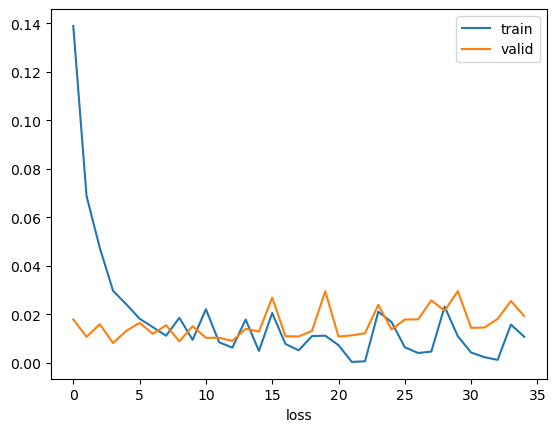

In [93]:
plt.plot(train_loss_hist, label='train')
plt.plot(valid_loss_hist, label='valid')
plt.xlabel('epoch')
plt.xlabel('loss')
plt.legend()
plt.show()